In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *

# Dandelion example

In [3]:
net = Network(100, 10, edge_weight="normal")

In [4]:
dp = DandelionProtocol(net, 0.5)

nx.draw(dp.line_graph, node_size=20)

In [5]:
%%time
adv = Adversary(net, 0.1)
sim = Simulator(dp, adv, 10, verbose=False)
sim.run(coverage_threshold=0.95)

CPU times: user 214 ms, sys: 1.85 ms, total: 215 ms
Wall time: 214 ms


In [6]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

{'estimator': 'first_reach', 'hit_ratio': 0.5, 'inverse_rank': 0.5306186868686869, 'entropy': 0.0, 'ndcg': 0.6176689633558624, 'message_spread_ratio': 0.8089999999999999}
CPU times: user 12.7 ms, sys: 3.86 ms, total: 16.5 ms
Wall time: 10.9 ms


In [7]:
%%time
evaluator = Evaluator(sim, "shortest_path")
print(evaluator.get_report())

{'estimator': 'shortest_path', 'hit_ratio': 0.0, 'inverse_rank': 0.15236688149962896, 'entropy': 4.220539975805851, 'ndcg': 0.32694489528565956, 'message_spread_ratio': 0.8089999999999999}
CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 19.5 ms


In [8]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

{'estimator': 'dummy', 'hit_ratio': 0.0, 'inverse_rank': 0.044031716867456404, 'entropy': 4.499809670330267, 'ndcg': 0.20869101411052196, 'message_spread_ratio': 0.8089999999999999}
CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 11.6 ms


# Experiment example

In [9]:
network_size = 1000
num_msg = 30
degree = 50
num_trials = 5
adversary_ratios = [0.01,0.05,0.1]
results = []

In [10]:
from tqdm.notebook import tqdm

In [11]:
def run_and_eval(net: Network, adv: Adversary, protocol: Protocol):
    sim = Simulator(protocol, adv, num_msg, verbose=False)
    sim.run(coverage_threshold=1.0)
    evaluator = Evaluator(sim)
    report = evaluator.get_report()
    report["protocol"] = str(protocol)
    report["adversary_ratio"] = adv.ratio
    return report, sim

### Simulation running time notes:
- became twice as slower.... :( after not sending event to node who has already boradcasted...
- become much faster after sending only to random sqrt neighbors
- running time scales linearly with number of messages... OK

**After several improvements: 27 sec for three protocols below (only one trial, 30 msg/simulation)**

In [12]:
%%time
# it could be parallelized
for adv_ratio in adversary_ratios:
    for _ in tqdm(range(num_trials)):
        # this part cannot be parallelized: it is important that different protocols will be evaluated with the same network and adversary setting
        net = Network(network_size, degree, edge_weight="normal")#, node_weight=)
        adv = Adversary(net, adv_ratio)
        # BUT: messages won't be the same!!!
        protocols = [
            BroadcastProtocol(net, broadcast_mode="sqrt"),
            DandelionProtocol(net, 0.5),
            DandelionProtocol(net, 0.25)
        ]
        for protocol in protocols:
            report, sim = run_and_eval(net, adv, protocol)
            results.append(report)
    print(adv_ratio)

  0%|          | 0/5 [00:00<?, ?it/s]

0.01


  0%|          | 0/5 [00:00<?, ?it/s]

0.05


  0%|          | 0/5 [00:00<?, ?it/s]

0.1
CPU times: user 6min 37s, sys: 6.35 s, total: 6min 43s
Wall time: 6min 40s


In [13]:
import seaborn as sns

In [14]:
results_df = pd.DataFrame(results)
results_df.head()

,estimator,hit_ratio,inverse_rank,entropy,ndcg,message_spread_ratio,protocol,adversary_ratio
0,first_reach,0.033333,0.035650,0.0,0.141843,0.759400,BroadcastProtocol(broadcast_mode=sqrt),0.01
1,first_reach,0.033333,0.048508,0.0,0.158893,0.716600,DandelionProtocol(0.5000),0.01
2,first_reach,0.000000,0.011004,0.0,0.128799,0.714267,DandelionProtocol(0.2500),0.01
3,first_reach,0.166667,0.177681,0.0,0.277280,0.773300,BroadcastProtocol(broadcast_mode=sqrt),0.01
4,first_reach,0.000000,0.006148,0.0,0.121616,0.709367,DandelionProtocol(0.5000),0.01


### Dummy adversary predicts message source for Dandelion much worse than in case of simple broadcasting

<AxesSubplot: xlabel='adversary_ratio', ylabel='entropy'>

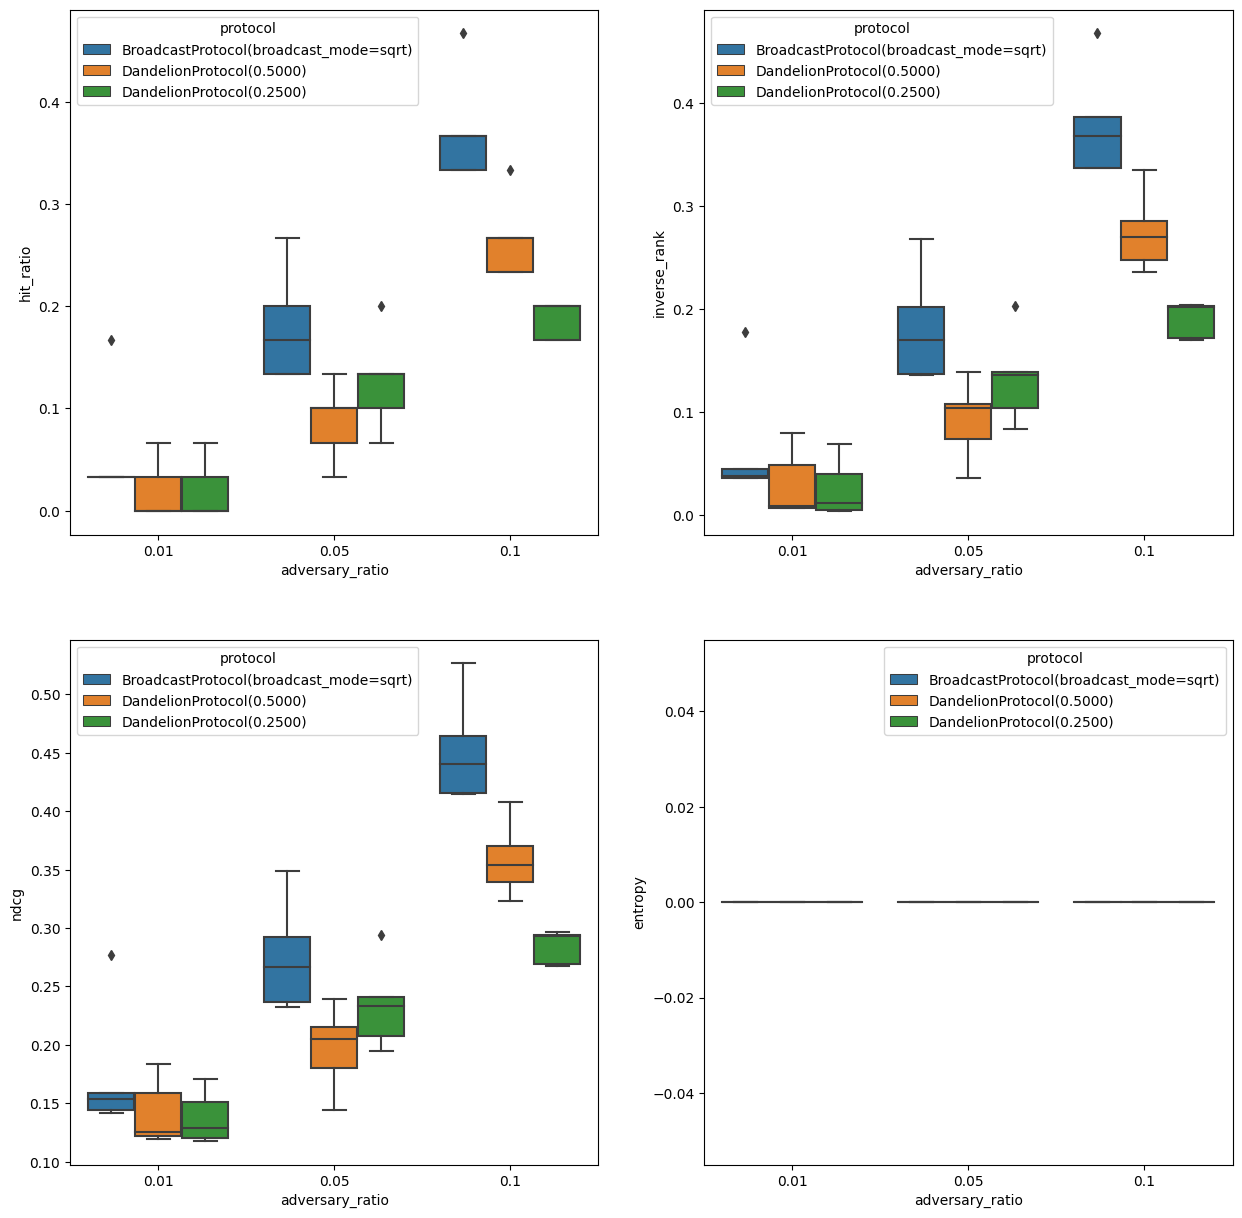

In [15]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
sns.boxplot(data=results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][0])
sns.boxplot(data=results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[0][1])
sns.boxplot(data=results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[1][0])
sns.boxplot(data=results_df, x="adversary_ratio", y="entropy", hue="protocol", ax=ax[1][1])

### While the fraction of nodes reached by messages are the same range for all protocols

<AxesSubplot: xlabel='adversary_ratio', ylabel='message_spread_ratio'>

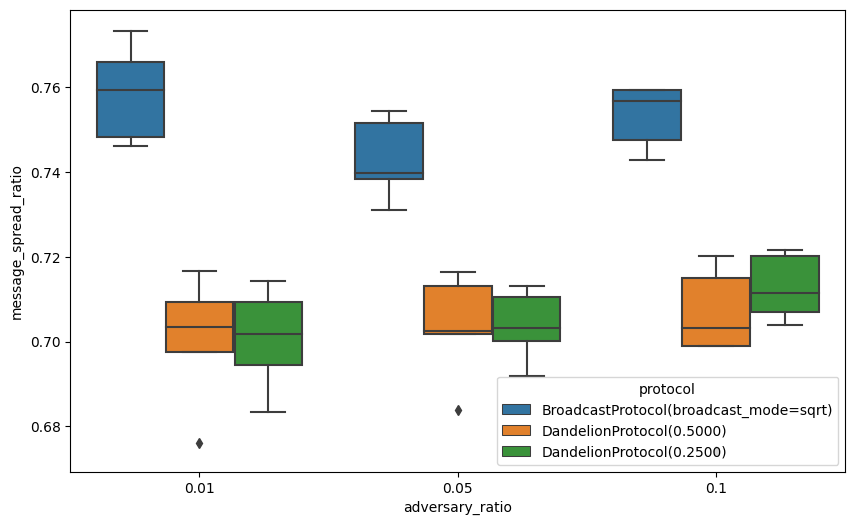

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.boxplot(data=results_df, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax)